In [48]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from thirdparty.fem_2d_rec import fem_poisson_solver,mesh_fem_2d_rec,get_matrices_2d

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [50]:
f_values = np.arange(-5000, 5000, 2)
np.savetxt('./f_constant.txt', f_values, fmt='%f')
print("Create f_constant.txt.")

Create f_constant.txt.


In [51]:
f_values = np.loadtxt('./f_constant.txt')
print(f"Loaded {len(f_values)} f values.")

Loaded 5000 f values.


In [52]:
def apply_boundary_conditions(f_matrix, g=0):
    f = f_matrix.copy()
    f[:, 0] = g  # 왼쪽 경계
    f[:, -1] = g  # 오른쪽 경계
    f[0, :] = g  # 아래쪽 경계
    f[-1, :] = g  # 위쪽 경계
    return f

In [53]:
# 256x256 크기의 f 행렬 생성 및 경계 값 0으로 설정
input_shape = (256, 256)
f_matrices = []
for f_value in f_values:
    f_matrix = np.full(input_shape, f_value)
    f_matrix_with_boundary = apply_boundary_conditions(f_matrix)
    f_matrices.append(f_matrix_with_boundary)

f_matrices = np.array(f_matrices)
print(f"{len(f_matrices)} f matrices with boundary conditions.")

5000 f matrices with boundary conditions.


In [54]:
f_matrices.shape

(5000, 256, 256)

In [55]:
f_matrices[3]

array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0., -4994., -4994., ..., -4994., -4994.,     0.],
       [    0., -4994., -4994., ..., -4994., -4994.,     0.],
       ...,
       [    0., -4994., -4994., ..., -4994., -4994.,     0.],
       [    0., -4994., -4994., ..., -4994., -4994.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [56]:
class PoissonDataset(Dataset):
    def __init__(self, f_matrices):
        self.f_matrices = f_matrices

    def __len__(self):
        return len(self.f_matrices)

    def __getitem__(self, idx):
        f_matrix = self.f_matrices[idx]
        f_tensor = torch.tensor(f_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return f_tensor

In [57]:
dataset = PoissonDataset(f_matrices)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [58]:
def create_boundary_mask(size):
    mask = torch.ones(size, dtype=torch.float32)
    mask[:, 0] = 0  # 왼쪽 경계
    mask[:, -1] = 0  # 오른쪽 경계
    mask[0, :] = 0  # 아래쪽 경계
    mask[-1, :] = 0  # 위쪽 경계
    return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W) 형태로 변환

# 경계 마스크 생성
boundary_mask = create_boundary_mask((256, 256)).to(device)

In [59]:
boundary_mask, 1-boundary_mask

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 1., 1.,  ..., 1., 1., 0.],
           [0., 1., 1.,  ..., 1., 1., 0.],
           ...,
           [0., 1., 1.,  ..., 1., 1., 0.],
           [0., 1., 1.,  ..., 1., 1., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 0., 0.,  ..., 0., 0., 1.],
           [1., 0., 0.,  ..., 0., 0., 1.],
           ...,
           [1., 0., 0.,  ..., 0., 0., 1.],
           [1., 0., 0.,  ..., 0., 0., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0'))

In [60]:
def unsupervised_loss(u_pred, f, h, boundary_mask):
    laplacian_filter = torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(u_pred.device) # (1, 1, H, W) 형태로 변환 / 마이너스 라플라시안 필터
    laplacian_u = torch.nn.functional.conv2d(u_pred, laplacian_filter, padding=1)

    # 내부 손실 계산 (경계를 제외한 부분)
    interior_loss = torch.sum(((f*h**2 - laplacian_u) ** 2) * boundary_mask)

    # 경계 손실 계산 (경계에서의 값이 0이 되도록)
    boundary_loss = torch.sum(((u_pred)* (1 - boundary_mask)) ** 2)

    return interior_loss + boundary_loss

In [61]:
class Autoencoder(nn.Module):
    def __init__(self, rep_dim=128):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, rep_dim),
            nn.ReLU()
        )

        # Latent space
        self.fc = nn.Linear(rep_dim, rep_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(rep_dim, 128 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        latent = self.fc(encoded)
        u_pred = self.decoder(latent)
        return u_pred, latent

In [62]:
a = 0
b = 1
k = 1
M = 255
h = 1 / M

In [63]:
# 모델 초기화
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 모델을 GPU로 이동
model = model.to(device)

# 경계 마스크 생성
boundary_mask = create_boundary_mask((256, 256)).to(device)

# 학습 루프
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for data in train_loader:
        inputs = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        u_pred, _ = model(inputs)
        loss = unsupervised_loss(u_pred, inputs, h, boundary_mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Loss: {train_loss}')

# 모델 저장
torch.save(model.state_dict(), 'autoencoder_model.pth')
print("Model saved to autoencoder_model.pth")


  1%|          | 1/100 [00:03<05:46,  3.50s/it]

Loss: 49374.85724460091


  2%|▏         | 2/100 [00:06<05:42,  3.50s/it]

Loss: 10045.615590478204


  3%|▎         | 3/100 [00:10<05:40,  3.51s/it]

Loss: 8768.285908887341


  4%|▍         | 4/100 [00:14<05:36,  3.51s/it]

Loss: 7507.877544038614


  5%|▌         | 5/100 [00:17<05:32,  3.50s/it]

Loss: 6159.106972469645


  6%|▌         | 6/100 [00:21<05:30,  3.51s/it]

Loss: 5137.629854044337


  7%|▋         | 7/100 [00:24<05:28,  3.54s/it]

Loss: 4560.10577431454


  8%|▊         | 8/100 [00:28<05:28,  3.57s/it]

Loss: 4346.6228291699845


  9%|▉         | 9/100 [00:31<05:24,  3.57s/it]

Loss: 4257.387811940187


 10%|█         | 10/100 [00:35<05:21,  3.58s/it]

Loss: 4162.4247253806725


 11%|█         | 11/100 [00:38<05:17,  3.57s/it]

Loss: 4115.621593694019


 12%|█▏        | 12/100 [00:42<05:12,  3.55s/it]

Loss: 4097.857929594198


 13%|█▎        | 13/100 [00:46<05:07,  3.54s/it]

Loss: 4087.8336344919385


 14%|█▍        | 14/100 [00:49<05:04,  3.53s/it]

Loss: 4076.1601127089966


 15%|█▌        | 15/100 [00:53<05:00,  3.54s/it]

Loss: 4063.5261012763735


 16%|█▌        | 16/100 [00:56<04:56,  3.53s/it]

Loss: 4057.52381770626


 17%|█▋        | 17/100 [01:00<04:55,  3.56s/it]

Loss: 4055.311692158887


 18%|█▊        | 18/100 [01:03<04:53,  3.58s/it]

Loss: 4051.260689316282


 19%|█▉        | 19/100 [01:07<04:53,  3.63s/it]

Loss: 4047.036401833698


 20%|██        | 20/100 [01:11<04:52,  3.66s/it]

Loss: 4043.7523963102108


 21%|██        | 21/100 [01:15<04:51,  3.69s/it]

Loss: 4040.0969953597732


 22%|██▏       | 22/100 [01:18<04:49,  3.71s/it]

Loss: 4037.0346380343103


 23%|██▎       | 23/100 [01:22<04:43,  3.68s/it]

Loss: 4033.857096872512


 24%|██▍       | 24/100 [01:26<04:38,  3.67s/it]

Loss: 4032.6885994103304


 25%|██▌       | 25/100 [01:29<04:33,  3.65s/it]

Loss: 4029.7396341311705


 26%|██▌       | 26/100 [01:33<04:29,  3.64s/it]

Loss: 4030.396005035206


 27%|██▋       | 27/100 [01:37<04:27,  3.67s/it]

Loss: 4027.8272837256172


 28%|██▊       | 28/100 [01:40<04:24,  3.68s/it]

Loss: 4025.1371719457543


 29%|██▉       | 29/100 [01:44<04:19,  3.66s/it]

Loss: 4025.8825565022266


 30%|███       | 30/100 [01:48<04:16,  3.67s/it]

Loss: 4020.5738890824045


 31%|███       | 31/100 [01:51<04:13,  3.67s/it]

Loss: 4018.180847751107


 32%|███▏      | 32/100 [01:55<04:11,  3.69s/it]

Loss: 4014.5243448634055


 33%|███▎      | 33/100 [01:59<04:06,  3.68s/it]

Loss: 4016.1806877767963


 34%|███▍      | 34/100 [02:02<04:03,  3.68s/it]

Loss: 4016.057446133559


 35%|███▌      | 35/100 [02:06<03:59,  3.68s/it]

Loss: 4014.5957171203227


 36%|███▌      | 36/100 [02:10<03:55,  3.68s/it]

Loss: 4011.2056223875397


 37%|███▋      | 37/100 [02:13<03:53,  3.71s/it]

Loss: 4014.622966013137


 38%|███▊      | 38/100 [02:17<03:49,  3.71s/it]

Loss: 4004.4048170344845


 39%|███▉      | 39/100 [02:21<03:45,  3.70s/it]

Loss: 4001.5765213693026


 40%|████      | 40/100 [02:25<03:41,  3.69s/it]

Loss: 3995.098569056031


 41%|████      | 41/100 [02:28<03:37,  3.69s/it]

Loss: 3992.776927777916


 42%|████▏     | 42/100 [02:32<03:34,  3.69s/it]

Loss: 3985.1229613480295


 43%|████▎     | 43/100 [02:35<03:28,  3.67s/it]

Loss: 3984.8133090073893


 44%|████▍     | 44/100 [02:39<03:26,  3.69s/it]

Loss: 3975.359671234325


 45%|████▌     | 45/100 [02:43<03:23,  3.71s/it]

Loss: 3973.5697830103004


 46%|████▌     | 46/100 [02:47<03:20,  3.70s/it]

Loss: 3974.3783464371018


 47%|████▋     | 47/100 [02:50<03:15,  3.69s/it]

Loss: 3965.81360329792


 48%|████▊     | 48/100 [02:54<03:11,  3.69s/it]

Loss: 3964.0895657873457


 49%|████▉     | 49/100 [02:58<03:08,  3.69s/it]

Loss: 3963.223466423666


 50%|█████     | 50/100 [03:01<03:03,  3.68s/it]

Loss: 3957.602283259106


 51%|█████     | 51/100 [03:05<02:59,  3.66s/it]

Loss: 3949.0698906965317


 52%|█████▏    | 52/100 [03:09<02:55,  3.66s/it]

Loss: 3951.7012815050257


 53%|█████▎    | 53/100 [03:12<02:52,  3.67s/it]

Loss: 3946.3711584783664


 54%|█████▍    | 54/100 [03:16<02:47,  3.64s/it]

Loss: 3936.180367828175


 55%|█████▌    | 55/100 [03:20<02:45,  3.67s/it]

Loss: 3943.4727689900974


 56%|█████▌    | 56/100 [03:23<02:40,  3.65s/it]

Loss: 3939.671487018561


 57%|█████▋    | 57/100 [03:27<02:37,  3.66s/it]

Loss: 3927.8077567519654


 58%|█████▊    | 58/100 [03:31<02:35,  3.70s/it]

Loss: 3926.65027516359


 59%|█████▉    | 59/100 [03:34<02:31,  3.71s/it]

Loss: 3928.9325573186206


 60%|██████    | 60/100 [03:38<02:29,  3.73s/it]

Loss: 3920.667552777916


 61%|██████    | 61/100 [03:42<02:24,  3.70s/it]

Loss: 3922.4639153936105


 62%|██████▏   | 62/100 [03:45<02:19,  3.67s/it]

Loss: 3918.103930042048


 63%|██████▎   | 63/100 [03:49<02:16,  3.68s/it]

Loss: 3921.442357543168


 64%|██████▍   | 64/100 [03:53<02:12,  3.67s/it]

Loss: 3898.2465485979797


 65%|██████▌   | 65/100 [03:57<02:08,  3.67s/it]

Loss: 3893.0901360967355


 66%|██████▌   | 66/100 [04:00<02:04,  3.67s/it]

Loss: 3885.0000198267066


 67%|██████▋   | 67/100 [04:04<02:01,  3.67s/it]

Loss: 3878.340975038565


 68%|██████▊   | 68/100 [04:07<01:56,  3.65s/it]

Loss: 3881.6727271596337


 69%|██████▉   | 69/100 [04:11<01:53,  3.65s/it]

Loss: 3874.177002730643


 70%|███████   | 70/100 [04:15<01:49,  3.65s/it]

Loss: 3873.5464283159586


 71%|███████   | 71/100 [04:18<01:45,  3.64s/it]

Loss: 3874.133156940436


 72%|███████▏  | 72/100 [04:22<01:42,  3.65s/it]

Loss: 3867.976573385251


 73%|███████▎  | 73/100 [04:26<01:38,  3.64s/it]

Loss: 3866.31336848751


 74%|███████▍  | 74/100 [04:29<01:34,  3.65s/it]

Loss: 3870.030686299512


 75%|███████▌  | 75/100 [04:33<01:31,  3.64s/it]

Loss: 3859.026992700662


 76%|███████▌  | 76/100 [04:37<01:27,  3.63s/it]

Loss: 3857.6325003265574


 77%|███████▋  | 77/100 [04:40<01:23,  3.63s/it]

Loss: 3862.419071659161


 78%|███████▊  | 78/100 [04:44<01:19,  3.62s/it]

Loss: 3855.7616619911923


 79%|███████▉  | 79/100 [04:47<01:15,  3.62s/it]

Loss: 3855.7386552361168


 80%|████████  | 80/100 [04:51<01:12,  3.62s/it]

Loss: 3858.938501443073


 81%|████████  | 81/100 [04:55<01:08,  3.63s/it]

Loss: 3854.9391182091586


 82%|████████▏ | 82/100 [04:58<01:05,  3.63s/it]

Loss: 3853.6858889828823


 83%|████████▎ | 83/100 [05:02<01:01,  3.62s/it]

Loss: 3852.4931181889433


 84%|████████▍ | 84/100 [05:06<00:58,  3.66s/it]

Loss: 3853.5211531523687


 85%|████████▌ | 85/100 [05:09<00:54,  3.63s/it]

Loss: 3859.3668341181083


 86%|████████▌ | 86/100 [05:13<00:50,  3.61s/it]

Loss: 3850.18990408539


 87%|████████▋ | 87/100 [05:16<00:46,  3.58s/it]

Loss: 3847.408203513759


 88%|████████▊ | 88/100 [05:20<00:42,  3.56s/it]

Loss: 3849.822354650801


 89%|████████▉ | 89/100 [05:23<00:39,  3.55s/it]

Loss: 3853.4399709519307


 90%|█████████ | 90/100 [05:27<00:35,  3.54s/it]

Loss: 3855.1065009050308


 91%|█████████ | 91/100 [05:30<00:31,  3.54s/it]

Loss: 3846.004562863878


 92%|█████████▏| 92/100 [05:34<00:28,  3.54s/it]

Loss: 3847.6790755934016


 93%|█████████▎| 93/100 [05:37<00:24,  3.55s/it]

Loss: 3848.4627561144007


 94%|█████████▍| 94/100 [05:41<00:21,  3.55s/it]

Loss: 3845.882603347681


 95%|█████████▌| 95/100 [05:45<00:17,  3.55s/it]

Loss: 3844.054030497363


 96%|█████████▌| 96/100 [05:48<00:14,  3.55s/it]

Loss: 3844.8183368269806


 97%|█████████▋| 97/100 [05:52<00:10,  3.55s/it]

Loss: 3846.384594571059


 98%|█████████▊| 98/100 [05:55<00:07,  3.56s/it]

Loss: 3844.3760605344346


 99%|█████████▉| 99/100 [05:59<00:03,  3.56s/it]

Loss: 3845.0841064453125


100%|██████████| 100/100 [06:03<00:00,  3.63s/it]

Loss: 3844.3454523754726
Model saved to autoencoder_model.pth


In [64]:
# 모델 로드
model.load_state_dict(torch.load('autoencoder_model.pth'))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=131072, out_features=128, bias=True)
    (11): ReLU()
  )
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=131072, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 32, 32))
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2)

In [103]:
f_matrices[2501]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 2., ..., 2., 2., 0.],
       [0., 2., 2., ..., 2., 2., 0.],
       ...,
       [0., 2., 2., ..., 2., 2., 0.],
       [0., 2., 2., ..., 2., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [104]:
f_tensor = torch.tensor(f_matrices[2501]).unsqueeze(0).unsqueeze(0).float().to(device)

with torch.no_grad():
    predicted_u, _ = model(f_tensor)
    
predicted_u = predicted_u.squeeze().cpu().numpy()

In [105]:
f = lambda x: np.full(x.shape[0], 2)
u_D = lambda x: x[:,0] * 0
c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)

fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
fem_u_reshaped = fem_u.reshape((256, 256))

In [106]:
# MSE 계산 및 시각화
mse = np.mean((predicted_u - fem_u_reshaped) ** 2)
print(f'Mean Squared Error: {mse}\n')
print(f'dl_u: \n{predicted_u}\n')
print(f'fem_u: \n{fem_u_reshaped}\n')

Mean Squared Error: 0.002967455754253757

dl_u: 
[[3.58398049e-03 1.38105941e-03 1.33443018e-03 ... 1.26074569e-03
  7.04965671e-04 3.78206768e-03]
 [9.88246175e-04 9.44152489e-05 9.14974007e-05 ... 1.43364538e-04
  1.68339306e-04 1.12734840e-03]
 [5.81626082e-04 1.86506877e-04 8.25816969e-05 ... 4.30499167e-05
  6.09150193e-05 1.36081723e-03]
 ...
 [1.40330801e-03 1.19814431e-04 7.62512427e-05 ... 6.65967673e-05
  7.61067568e-05 1.23692374e-03]
 [5.56100276e-04 1.21530764e-04 8.67212366e-05 ... 9.96412346e-05
  1.42254867e-04 2.21450720e-03]
 [5.68535412e-03 1.12671126e-03 9.41720151e-04 ... 1.52245129e-03
  6.59241050e-04 3.41308047e-03]]

fem_u: 
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0001046  0.00019172 ... 0.00019172 0.0001046  0.        ]
 [0.         0.00019172 0.00036105 ... 0.00036105 0.00019172 0.        ]
 ...
 [0.         0.00019172 0.00036105 ... 0.00036105 0.00019172 0.        ]
 [0.         0.0001046  0.00019172 ... 0.0001

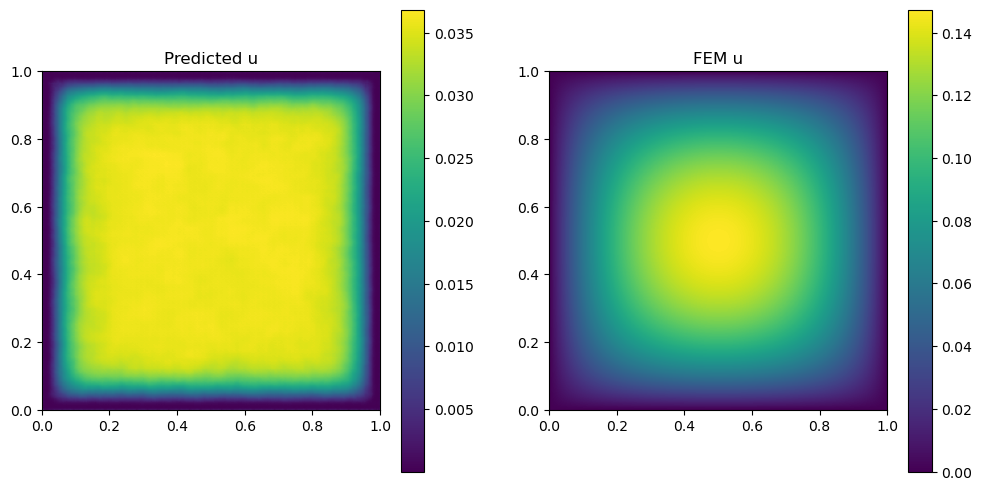

In [107]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Predicted u")
plt.imshow(predicted_u, cmap='viridis', extent=(0, 1, 0, 1))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("FEM u")
plt.imshow(fem_u.reshape((256, 256)), cmap='viridis', extent=(0, 1, 0, 1))
plt.colorbar()

plt.show()

In [ ]:
constant_value = -2
new_f = np.full((256, 256), constant_value)
new_f = apply_boundary_conditions(new_f)
print(f'Input new_f:\n {new_f}\n')

f_tensor = torch.tensor(new_f).unsqueeze(0).unsqueeze(0).float().to(device)

with torch.no_grad():
    predicted_u, _ = model(f_tensor)

predicted_u = predicted_u.squeeze().cpu().numpy()

f = lambda x: np.full(x.shape[0], constant_value)
u_D = lambda x: x[:,0] * 0

c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)

fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
fem_u_reshaped = fem_u.reshape((256, 256))

mse = np.mean((predicted_u - fem_u_reshaped) ** 2)
print(f'Mean Squared Error: {mse}\n')
print(f'Predicted u: \n{predicted_u}\n')
print(f'FEM u: \n{fem_u_reshaped}\n')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Predicted u")
plt.imshow(predicted_u, cmap='viridis', extent=(0, 1, 0, 1))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("FEM u")
plt.imshow(fem_u.reshape((256, 256)), cmap='viridis', extent=(0, 1, 0, 1))
plt.colorbar()

plt.show()